In [2]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L

In [3]:
hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

In [10]:
def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def phi(psi):
    phi0 = math.atan2(np.real(psi[0]),np.imag(psi[0]))
    phi1 = math.atan2(np.real(psi[1]),np.imag(psi[1]))
    return (phi0-phi1)

def blochVec(psi):
    w = rhogg(psi) - rhoee(psi)  #pointed up is ground state
    if abs(w)>1.0:
        w = float(round(w))
    x = np.sin(np.arccos(w))*np.cos(phi(psi))
    y = np.sin(np.arccos(w))*np.sin(phi(psi))
    return np.array([x,y,w])

In [28]:
def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    result = psi(0.0+0.0j,0.0+0.0j)
    for n in range(Ncut):
        result += prob(n,nbar)*pulse(t, Omega0*Omega(n,0,eta), delPrime, 0.0, 0.0)@psi0
    return result

def therm3DPulse(psi0, t, Omega0, delPrime, nbars, Omegas, Ncut):
    nbarx = nbars[0]
    nbary = nbars[1]
    nbarz = nbars[2]
    #Ncut = 100
    result = psi(0.0+0.0j,0.0+0.0j)
    for nx in range(Ncut):
        Probx = prob(nx,nbarx)
        for ny in range(Ncut):
            Probxy = Probx*prob(ny,nbary)
            for nz in range(Ncut):
                result += Probxy*prob(nz,nbarz)*pulse(t, Omega0*Omegas[nx,ny,nz], delPrime, 0.0, 0.0)@psi0
    return result

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2)              #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

In [6]:
def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n

def expE(nbar, omega, Ncut):
    expE = 0.0
    #Ncut = 1001
    for n in range(Ncut):
        expE += prob(n,nbar)*hbar*omega*(0.5+n)
    return expE

def expEHeat(nbar0, nbarf, omega, Ncut):
    return expE((nbar0+nbarf)/2.0, omega, Ncut)

def dopAndStark(nbar): #gives instantaneous doppler and stark shift in angular frequency units
    Ncut = 1201
    omega = 2.0*np.pi*778e3 #Lange
    Omegarf = 2.0*np.pi*13e6 #Lange
    m = 170.936331517*amutokg
    alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
    nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)
    return -2.0*np.pi*nu0*expE(nbar, omega, Ncut)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))

def excMic():
    beta= 0.018
    theta = 0.0
    Omegarf = 2.0*np.pi*13e6 #Lange
    m = 170.936331517*amutokg
    alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
    nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)
    dop = -0.25*(beta*Omegarf/(2.0*np.pi*nu0*np.cos(theta)))**2
    stark = -(alpha/(h*nu0))*(beta*m*Omegarf**2*c/(4*np.pi*nu0*e*np.cos(theta)))**2
    return 2.0*np.pi*(dop + stark)*nu0

In [13]:
def MHRSthermPulse(psi0, t, Omega0, delPrime, phi0, phi1, eta, nbar, Ncut): #1-dimensional
    result = psi(0.0+0.0j,0.0+0.0j)
    for n in range(Ncut):
        result += prob(n,nbar)*pulse(t, Omega0*Omega(n,0,eta), delPrime, phi0, phi1)@psi0
    return result

def HRAThermp(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    delp1 = delPrime 
    delp2 = delPrime + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    freeEvo = pulse(T, 0.0, deld, 0.0, phi)
    state1 = MHRSthermPulse(psi0, t, Omega0, delp1, np.pi/2.0, -np.pi/2.0, eta, nbar0, Ncut)
    state2 = freeEvo@state1
    state3 = MHRSthermPulse(state2, 2.0*t, Omega0, delp2, np.pi, -np.pi, eta, nbarf, Ncut)
    state4 = MHRSthermPulse(state3, t, Omega0, delp2, 0.0, 0.0, eta, nbarf, Ncut)
    return state4

def HRAThermn(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    delp1 = delPrime
    delp2 = delPrime + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    freeEvo = pulse(T, 0.0, deld, 0.0, phi)
    state1 = MHRSthermPulse(psi0, t, Omega0, delp1, -np.pi/2.0, np.pi/2.0, eta, nbar0, Ncut)
    state2 = freeEvo@state1
    state3 = MHRSthermPulse(state2, 2.0*t, Omega0, delp2, np.pi, -np.pi, eta, nbarf, Ncut)
    state4 = MHRSthermPulse(state3, t, Omega0, delp2, 0.0, 0.0, eta, nbarf, Ncut)
    return state4
    
def HRBThermp(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    delp1 = delPrime
    delp2 = delPrime + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    freeEvo = pulse(T, 0.0, deld, 0.0, phi)
    state1 = MHRSthermPulse(psi0, t, Omega0, delp1, 0.0, 0.0, eta, nbar0, Ncut)
    state2 = freeEvo@state1
    state3 = MHRSthermPulse(state2, 2.0*t, Omega0, delp2, np.pi, -np.pi/2.0, eta, nbarf, Ncut)
    state4 = MHRSthermPulse(state3, t, Omega0, delp2, 0.0, -np.pi/2.0, eta, nbarf, Ncut)
    return state4

def HRBThermn(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    delp1 = delPrime
    delp2 = delPrime + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    freeEvo = pulse(T, 0.0, deld, 0.0, phi)
    state1 = MHRSthermPulse(psi0, t, Omega0, delp1, 0.0, 0.0, eta, nbar0, Ncut)
    state2 = freeEvo@state1
    state3 = MHRSthermPulse(state2, 2.0*t, Omega0, delp2, np.pi, -3.0*np.pi/2.0, eta, nbarf, Ncut)
    state4 = MHRSthermPulse(state3, t, Omega0, delp2, 0.0, np.pi/2.0, eta, nbarf, Ncut)
    return state4

def MHRThermES1(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    return rhoee(HRAThermp(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut)) - rhoee(HRBThermn(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut))
def MHRThermES2(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    return rhoee(HRBThermp(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut)) - rhoee(HRAThermn(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut))

In [80]:
def RamseyErrSig(deld, psi0, t1, T, t2, delPrime, Omega0, eta, nbar0, nbarf, Ncut, delExc):
    delp1 = delPrime
    delp2 = delPrime + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T + delExc*T
    freeEvo = pulse(T, 0.0, deld, 0.0, phi)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    intState = thermPulse(psi0, t1, Omega0, delp1, eta, nbar0, Ncut)
    resultP = thermPulse(freeEvo@pi2PhaseInjP@intState, t2, Omega0, delp2, eta, nbarf, Ncut)
    resultM = thermPulse(freeEvo@pi2PhaseInjM@intState, t2, Omega0, delp2, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

def HRJumpThermErrSig(deld, psi0, t1, T, t2, delPrime, Omega0, eta, nbar0, nbarf, Ncut, delExc):
    delp1 = delPrime
    delp2 = delPrime + dopAndStark(nbarf) - dopAndStark(nbar0) #- 0.3*2*np.pi*1e-3
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T + delExc*T
    freeEvo = pulse(T, 0.0, deld, 0.0, phi)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    #def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    intState = thermPulse(psi0, t1, Omega0, delp1, eta, nbar0, Ncut)
    resultP = thermPulse(thermPulse(freeEvo@pi2PhaseInjP@intState, 2.0*t2/3.0, -Omega0, delp2, eta, nbarf, Ncut), t2/3.0, Omega0, delp2, eta, nbarf, Ncut)
    resultM = thermPulse(thermPulse(freeEvo@pi2PhaseInjM@intState, 2.0*t2/3.0, -Omega0, delp2, eta, nbarf, Ncut), t2/3.0, Omega0, delp2, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

def HRJumpThermErrSigFront(deld, psi0, t1, T, t2, delPrime, Omega0, eta, nbar0, nbarf, Ncut, delExc):
    delp1 = delPrime
    delp2 = delPrime + dopAndStark(nbarf) - dopAndStark(nbar0) #-0.4*2.0*np.pi*1e-3
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T + delExc*T
    freeEvo = pulse(T, 0.0, deld, 0.0, phi)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    #def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    intState = thermPulse(thermPulse(psi0, t1/3.0, Omega0, delp1, eta, nbar0, Ncut), 2.0*t1/3.0, -Omega0, delp1, eta, nbar0, Ncut)
    resultP = thermPulse(freeEvo@pi2PhaseInjP@intState, t2, Omega0, delp2, eta, nbarf, Ncut)
    resultM = thermPulse(freeEvo@pi2PhaseInjM@intState, t2, Omega0, delp2, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

In [101]:
Ncut = 401
psi0 = psi(1.0, 0.0)
t1 = 60.0e-3
t2 = 20e-3
T = 500.0e-3
q = 1.0
Omega0 = q*np.pi/(2.0*t2)
delPrime = +1450e-3*2.0*np.pi
nbar0 = 0.0
eta = 0.05
delExc = 0.0 #excMic()#-0.01e-3*2.0*np.pi

pts = 5
nbarfs = np.linspace(0, 40, pts)
nbarfStars = nbarfs*(t1+T)/(t1+t2+T)
nbar0s = nbarfs*t1/(t1+t2+T)
shifts1 = np.zeros(pts)

tol = 1.0e-11
x0 = -0.1
x1 = 0.1
guessTol = 0.1

for ii in range(pts):
    print(nbarfs[ii])
    shifts1[ii] = (1.0/(2.0*np.pi))*sp.optimize.root_scalar(HRJumpThermErrSigFront, args=(psi0, t1, T, t2, delPrime, Omega0, eta, nbar0s[ii], nbarfs[ii], Ncut, delExc), bracket=[x0,x1], xtol = tol).root
    print(shifts1[ii])
    x0 = shifts1[ii]*(2.0*np.pi) - guessTol
    x1 = shifts1[ii]*(2.0*np.pi) + guessTol
    #print(x0,x1)

0.0
-0.0019771358180248238
10.0
-0.0020385422699570367
20.0
-0.0021470954829159476
30.0
-0.002297535774176407
40.0
-0.002485540648573562


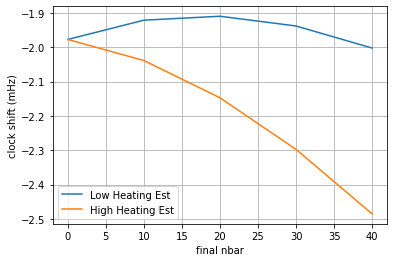

In [102]:
#plt.plot(nbarfs, 1e3*np.array([-7.26022535e-05, -8.41610515e-04, -1.62399530e-03, -2.42310390e-03,-3.24313556e-03]), label=r"$\delta_p= 0 mHz$")
#plt.plot(nbarfs, 1e3*np.array([-4.29337525e-05, -2.26224345e-04, -3.26708160e-04, -3.30159122e-04,-2.19061842e-04]), label=r"$\delta_p= +15 mHz$")
#plt.plot(nbarfs, 1e3*np.array([-3.30621195e-05, -2.11174313e-05,  1.05693770e-04,  3.67454795e-04,7.88918419e-04]), label=r"$\delta_p= +20 mHz$")
#plt.plot(nbarfs, 1e3*np.array([-7.26022535e-05, -8.35073994e-04, -1.59662748e-03, -2.35735735e-03,-3.11733063e-03]), label=r"$\delta_p= 0 mHz$")
#plt.plot(nbarfs, 1e3*np.array([ 5.90687124e-06,  3.18196609e-05, -5.96595513e-06, -9.22178723e-05,-2.16252138e-04]), label=r"$\delta_p= -230 mHz$")
#plt.plot(nbarfs, 1e3*np.array([ 1.65921690e-05,  7.73264841e-05,  7.15563125e-05,  1.51778411e-05,-8.06604853e-05]), label=r"$\delta_{excess}= 0 mHz$")
#plt.plot(nbarfs, 1e3*np.array([-9.05651295e-05, -2.98308166e-05, -3.56009842e-05, -9.19794595e-05,-1.87817786e-04]), label=r"$\delta_{excess}= -0.0109 mHz$")
#plt.plot(nbarfs, 1e3*np.array([-1.15678651e-04, -5.49443379e-05, -6.07145095e-05, -1.17092981e-04,-2.12931307e-04]), label=r"$\delta_p^{1st}= -0.1 mHz$")

#plt.plot(nbarfs, 1e3*np.array([ 1.65921690e-05,  7.73264841e-05,  7.15563125e-05,  1.51778411e-05, -8.06604853e-05]), label=r"$\delta_p= -240 mHz$")
#plt.plot(nbarfs, 1e3*np.array([2.82045845e-05, 1.23829405e-04, 1.50144033e-04, 1.23708438e-04, 5.61351836e-05]), label=r"$\delta_p= -250 mHz$")
#plt.plot(nbarfs, 1e3*np.array([-3.81623798e-05,  4.69878769e-05,  6.36696107e-05,  2.82436977e-05,-4.78165046e-05]), label=r"$\delta_p^{1st}= +0.25 mHz$")
#plt.plot(nbarfs, 1e3*shifts1, label=r"$\delta_p^{2nd}= -0.3 mHz$")
#plt.plot(nbarfs, 1e3*np.array([ 1.65921690e-05,  7.73264841e-05,  7.15563125e-05,  1.51778411e-05,-8.06604853e-05]), label=r"$\delta_p= -240 mHz$")
#plt.plot(nbarfs, 1e3*np.array([-3.82653929e-05, -4.01456145e-04, -7.69563591e-04, -1.14147548e-03,-1.51632171e-03]), label="Low Heating Est")
#plt.plot(nbarfs, 1e3*np.array([-3.82653929e-05, -4.61705409e-04, -8.91105698e-04, -1.32497138e-03,-1.76225437e-03]), label="High Heating Est")

#plt.plot(nbarfs, 1e3*np.array([-4.62200301e-05, -5.31624616e-04, -1.01644462e-03, -1.50074028e-03,-1.98455428e-03]), label=r"$\delta_p = 0 mHz$")
#plt.plot(nbarfs, 1e3*np.array([-4.55657933e-05, -4.96434214e-04, -9.49563402e-04, -1.40433745e-03,-1.86032424e-03]), label=r"$\delta_p = -100 mHz$")
#plt.plot(nbarfs, 1e3*np.array([ 3.52471334e-05, -2.71321201e-04, -5.91455341e-04, -9.21859562e-04,-1.26023464e-03]), label=r"$\delta_p = -500 mHz$")
#plt.plot(nbarfs, 1e3*np.array([5.97888688e-04, 5.06380458e-04, 3.87348010e-04, 2.47292396e-04, 9.06624451e-05]), label=r"$\delta_p = -1000 mHz$")
#plt.plot(nbarfs, 1e3*np.array([0.0020867 , 0.00227818, 0.00242804, 0.00254572, 0.00263746]), label=r"$\delta_p = -1500 mHz$")
#plt.plot(nbarfs, 1e3*shifts1, label=r"$\delta_p = -1250 mHz$")

#plt.plot(nbarfs, 1e3*np.array([-4.62200301e-05, -4.85215266e-04, -9.24785638e-04, -1.36485037e-03,-1.80533968e-03]), label=r"$\delta_p = 0 mHz$")
#plt.plot(nbarfs, 1e3*np.array([-4.68742669e-05, -4.51486843e-04, -8.59949372e-04, -1.27181891e-03, -1.68672824e-03]), label=r"$\delta_p = +100 mHz$")
#plt.plot(nbarfs, 1e3*np.array([-0.00129341, -0.00130406, -0.00135601, -0.00144471, -0.00156638]), label=r"$\delta_p = +1250 mHz$")
#plt.plot(nbarfs, 1e3*np.array([-0.00178792, -0.00174756, -0.00175336, -0.00180019, -0.00188387]), label=r"$\delta_p = +1400 mHz$")

plt.plot(nbarfs, 1e3*np.array([-0.00197714, -0.00192096, -0.00190948, -0.00193791, -0.00200223]), label="Low Heating Est")
plt.plot(nbarfs, 1e3*shifts1, label="High Heating Est")

plt.xlabel("final nbar")
plt.ylabel("clock shift (mHz)")
plt.grid()
plt.legend()
plt.show()

In [103]:
shifts1

array([-0.00197714, -0.00203854, -0.0021471 , -0.00229754, -0.00248554])

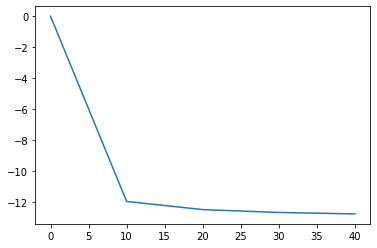

In [51]:
err = (np.array([-4.62200301e-05, -4.81438698e-04, -9.16181706e-04, -1.35049496e-03,-1.78441133e-03])-shifts1)/shifts1*100
plt.plot(nbarfs, err)

In [458]:
Ncut = 401
psi0 = psi(1.0, 0.0)
t1 = 60.0e-3
t2 = 20.0e-3
T = 500.0e-3
q = 1.0
Omega0 = q*np.pi/(2.0*t2)
delPrime = +235e-3*2.0*np.pi
nbar0 = 0.0
eta = 0.05
delExc = 0.0 #excMic()#-0.1e-3*2.0*np.pi

pts = 5
nbarfs = np.linspace(0, 40, pts)
shifts1 = np.zeros(pts)

tol = 1.0e-11
x0 = -0.1
x1 = 0.1
guessTol = 0.1

for ii in range(pts):
    print(nbarfs[ii])
    shifts1[ii] = (1.0/(2.0*np.pi))*sp.optimize.root_scalar(HRJumpThermErrSigFront, args=(psi0, t1, T, t2, delPrime, Omega0, eta, nbar0, nbarfs[ii], Ncut, delExc), bracket=[x0,x1], xtol = tol).root
    print(shifts1[ii])
    x0 = shifts1[ii] - guessTol
    x1 = shifts1[ii] + guessTol
    #print(x0,x1)

0.0
-5.588622750520059e-05
10.0
5.05681005315803e-05
20.0
8.030340474999787e-05
30.0
4.183053493466968e-05
40.0
-5.785492857427382e-05


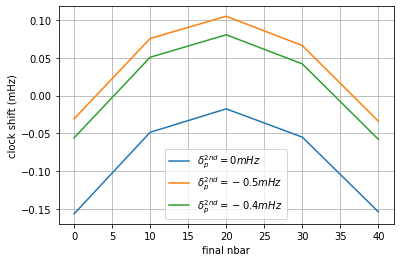

In [459]:
#plt.plot(nbarfs, 1e3*np.array([-4.62200301e-05, -4.85215266e-04, -9.24785638e-04, -1.36485037e-03,-1.80533968e-03]), label=r"$\delta_p = 0 mHz$")
#plt.plot(nbarfs, 1e3*np.array([-5.03307211e-05, -2.73292313e-04, -5.17405524e-04, -7.80313997e-04,-1.06007897e-03]), label=r"$\delta_p = 100 mHz$")
#plt.plot(nbarfs, 1e3*np.array([-7.90897739e-05, -8.60454565e-05, -1.34725415e-04, -2.20498351e-04,-3.39557026e-04]), label=r"$\delta_p = 200 mHz$")
#plt.plot(nbarfs, 1e3*np.array([-9.62004899e-05, -3.83638909e-05, -2.84220658e-05, -6.10614373e-05,-1.31914401e-04]), label=r"$\delta_{excess} = 230 mHz$")

#plt.plot(nbarfs, 1e3*np.array([-1.10395656e-04, -9.36732211e-06,  3.96530073e-05,  4.24336793e-05,3.71582601e-06]), label=r"$q = 1.0 $")
#plt.plot(nbarfs, 1e3*np.array([-0.00012938, -0.00018083, -0.00026748, -0.00038573, -0.00053259]), label=r"$q = 0.9 $")
#plt.plot(nbarfs, 1e3*np.array([-1.78614113e-04, -7.75857784e-05, -2.85654490e-05, -2.57847770e-05,-6.45026303e-05]), label=r"$\delta_{excess} = -0.068 mHz$")
#plt.plot(nbarfs, 1e3*np.array([-1.10395656e-04, -9.36732211e-06,  3.96530073e-05,  4.24336793e-05,3.71582601e-06]), label=r"$\delta_{excess} = 0.0 mHz$")
#plt.plot(nbarfs, 1e3*shifts1, label=r"$\delta_p^{2nd} = -0.5 mHz$")

#plt.plot(nbarfs, 1e3*np.array([-1.73409091e-04, -1.47141552e-05,  6.22867983e-05,  6.66546661e-05,5.83680584e-06]), label=r"$\delta_p = +250 mHz$")
#plt.plot(nbarfs, 1e3*np.array([-1.61796678e-04, -3.70239330e-05,  9.28528316e-06, -1.41652990e-05,-1.00221679e-04]), label=r"$\delta_p = +240 mHz$")
#plt.plot(nbarfs, 1e3*np.array([-1.51111376e-04, -6.02618589e-05, -4.46452741e-05, -9.59150815e-05,-2.07210657e-04]), label=r"$\delta_p = +230 mHz$")

plt.plot(nbarfs, 1e3*np.array([-1.56340538e-04, -4.85292799e-05, -1.75662700e-05, -5.49263698e-05, -1.53602265e-04]), label=r"$\delta_p^{2nd} = 0 mHz$")
plt.plot(nbarfs, 1e3*np.array([-3.07726472e-05,  7.53424481e-05,  1.04770828e-04,  6.60197632e-05, -3.39180926e-05]), label=r"$\delta_p^{2nd} = -0.5 mHz$")
plt.plot(nbarfs, 1e3*shifts1, label=r"$\delta_p^{2nd} = -0.4 mHz$")

plt.xlabel("final nbar")
plt.ylabel("clock shift (mHz)")
plt.grid()
plt.legend()
plt.show()

In [460]:
shifts1

array([-5.58862275e-05,  5.05681005e-05,  8.03034047e-05,  4.18305349e-05,
       -5.78549286e-05])

In [342]:
1e4*(-0.00073871+1.10395656e-04)/(2*np.pi)

-0.9999933366314155

In [345]:
1.3e-19*nu0*1e3

0.08948666731021002

In [424]:
excMic()/(2*np.pi)*1e3

-0.010857304536317832

In [507]:
Ncut = 401
psi0 = psi(1.0, 0.0)
t = 20.0e-3
T = 500.0e-3
q = 1.0
Omega0 = q*np.pi/(2.0*t1)
delPrime = -1000e-3*2.0*np.pi
nbar0 = 0.0
eta = 0.05
delExc = 0.0 #excMic()#-0.1e-3*2.0*np.pi

pts = 5
nbarfs = np.linspace(0, 40, pts)
shifts1 = np.zeros(pts)

tol = 1.0e-11
x0 = -0.1
x1 = 0.1
guessTol = 0.1

for ii in range(pts):
    print(nbarfs[ii])
    #MHRThermES1(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    shifts1[ii] = (1.0/(2.0*np.pi))*sp.optimize.root_scalar(MHRThermES1, args=(psi0, t, T,  delPrime, Omega0, eta, nbar0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
    print(shifts1[ii])
    x0 = shifts1[ii] - guessTol
    x1 = shifts1[ii] + guessTol
    #print(x0,x1)

0.0
-7.26022534843704e-05
10.0
0.009288209012849113
20.0
0.010373629658652104
30.0
0.003972713523235112
40.0
-0.009099917056732227


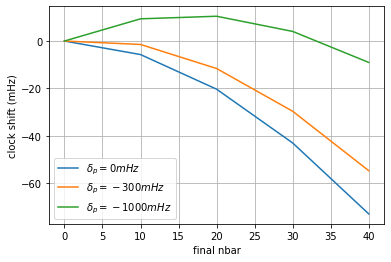

In [508]:
plt.plot(nbarfs, 1e3*np.array([-7.26022535e-05, -5.78011445e-03, -2.03741319e-02, -4.30492965e-02,-7.29506135e-02]), label=r"$\delta_p = 0 mHz$")
plt.plot(nbarfs, 1e3*np.array([-7.26022535e-05, -1.52152115e-03, -1.16601874e-02, -2.96813245e-02,-5.47359404e-02]), label=r"$\delta_p = -300 mHz$")
plt.plot(nbarfs, 1e3*shifts1, label=r"$\delta_p = -1000 mHz$")

plt.xlabel("final nbar")
plt.ylabel("clock shift (mHz)")
plt.grid()
plt.legend()
plt.show()

In [509]:
shifts1

array([-7.26022535e-05,  9.28820901e-03,  1.03736297e-02,  3.97271352e-03,
       -9.09991706e-03])

In [8]:
excMic()/(2*np.pi)*1e3

-0.06821845633816648

In [24]:
Ncut = 401
psi0 = psi(1.0, 0.0)
t1 = 20.0e-3
t2 = 3.0*t1
T = 500.0e-3
q = 1.0
Omega0 = q*np.pi/(2.0*t1)
delPrime = -230e-3*2.0*np.pi
nbar0 = 0.0
nbarf = 0.0
eta = 0.05
delExc = 1e-5*(2.0*np.pi)#excMic()#-0.01e-3*2.0*np.pi    #in angular frequency units!
tol = 1.0e-11
x0 = -0.1
x1 = 0.1
guessTol = 0.1

(1.0/(2.0*np.pi))*sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, t2, delPrime, Omega0, eta, nbar0, nbarf, Ncut, delExc), bracket=[x0,x1], xtol = tol).root

-7.605164665417463e-05

In [89]:
nbar0

0.0

In [104]:
dopAndStark(40)*1e3

-23.52313012884458

In [7]:
omega = 2.0*np.pi*778e3 #Lange
Omegarf = 2.0*np.pi*13e6 #Lange
m = 170.936331517*amutokg
alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)
-2.0*np.pi*nu0*expE(10.0, omega, 401)*(3.0/(m*c**2))

-0.002753062988498654

In [10]:
1e3*dopAndStark(10)

-6.098589292688097